# Runtime Comparison

This script compares the running time of two versions of Variational autoencoders (in an epoch):
- Normal Tensorflow
- Parallelized Tensorflow

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import tensorflow as tf
import time
from tensorflow.python.client import timeline
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

### Prepare Dataset

In [3]:
from misc_sta663 import *
(mnist, n_samples) = mnist_loader()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Normal Tensorflow

In [4]:
from vae_sta663 import *
import tensorflow as tf
import numpy as np

config_normal = {}
config_normal['x_in'] = 784
config_normal['encoder_1'] = 500
config_normal['encoder_2'] = 500
config_normal['decoder_1'] = 500
config_normal['decoder_2'] = 500
config_normal['z'] = 20

### Parallelized Tensorflow

In [5]:
from vae_parallel_sta663 import *

In [6]:
import tensorflow as tf
import numpy as np

config_parallel = {}
config_parallel['x_in'] = 784
config_parallel['encoder_1'] = 500
config_parallel['encoder_2'] = 500
config_parallel['decoder_1'] = 500
config_parallel['decoder_2'] = 500
config_parallel['z'] = 20

### Across Batch Sizes

In [7]:
batch_size = np.arange(100, 1100, 100)
run_time_parallel = []

In [8]:
def vae_train(sess, optimizer, cost, x, n_samples, batch_size=100, learn_rate=0.001, train_epoch=10, verb=1, verb_step=5):
    
    for epoch in range(train_epoch):
        avg_cost = 0
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            batch_x, _ = mnist.train.next_batch(batch_size)
            
            _, c = sess.run((optimizer, cost), feed_dict={x: batch_x})
            avg_cost += c / n_samples * batch_size
        
        if verb:
            if epoch % verb_step == 0:
                print('Epoch:%04d' % (epoch+1), 'cost=', '{:.9f}'.format(avg_cost))

In [9]:
for s in batch_size:
    print('Evaluating at: %d' % s)
    
    (sess_2, optimizer_2, cost_2, x_2, x_prime_2) = vae_init_parallel(batch_size=s, config=config_parallel)
    result_2 = %timeit -o -n1 -r5 vae_train(sess_2, optimizer_2, cost_2, x_2, n_samples, batch_size=s, train_epoch=1, verb=0)
    sess_2.close()
    run_time_parallel.append(result_2.all_runs)

Evaluating at: 100
1 loop, best of 5: 7.8 s per loop
Evaluating at: 200
1 loop, best of 5: 5.89 s per loop
Evaluating at: 300
1 loop, best of 5: 5.24 s per loop
Evaluating at: 400
1 loop, best of 5: 5.15 s per loop
Evaluating at: 500
1 loop, best of 5: 4.88 s per loop
Evaluating at: 600
1 loop, best of 5: 4.72 s per loop
Evaluating at: 700
1 loop, best of 5: 4.74 s per loop
Evaluating at: 800
1 loop, best of 5: 4.6 s per loop
Evaluating at: 900
1 loop, best of 5: 4.61 s per loop
Evaluating at: 1000
1 loop, best of 5: 4.64 s per loop


In [12]:
import pickle

with open('../]data/runtime_parallel.pickle', 'wb') as f:
    pickle.dump(run_time_parallel, f)

with open('../]data/runtime_normal.pickle', 'rb') as f:
    run_time_normal = pickle.load(f)

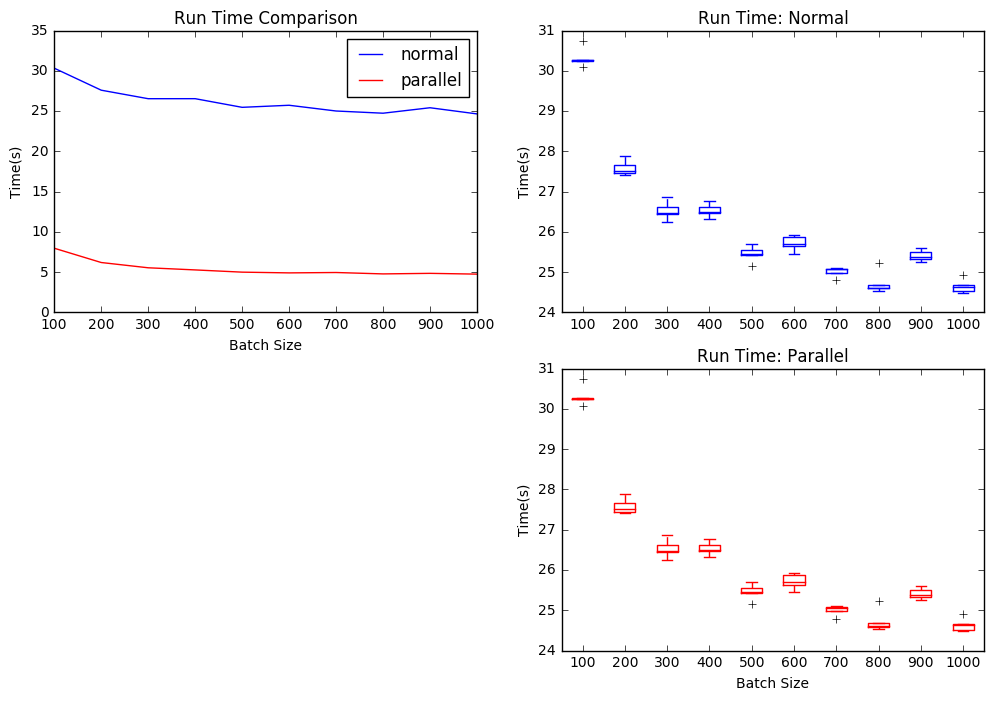

In [49]:
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.plot(batch_size, np.mean(run_time_normal, axis=1), 'b', label='normal')
plt.plot(batch_size, np.mean(run_time_parallel, axis=1), 'r', label='parallel')
plt.xlabel('Batch Size')
plt.ylabel('Time(s)')
plt.legend(loc='best')
plt.title('Run Time Comparison')

ax = plt.subplot(2,2,2)
bp1 = plt.boxplot(run_time_normal)
plt.setp(bp1['boxes'], color='blue')
plt.setp(bp1['caps'], color='blue')
plt.setp(bp1['whiskers'], color='blue')
plt.setp(bp1['fliers'], color='blue')
plt.setp(bp1['medians'], color='blue')
plt.ylabel('Time(s)')
ax.set_xticklabels((x*10+50)*2)
plt.title('Run Time: Normal')

ax = plt.subplot(2,2,4)
bp2 = plt.boxplot(run_time_normal)
plt.setp(bp2['boxes'], color='red')
plt.setp(bp2['caps'], color='red')
plt.setp(bp2['whiskers'], color='red')
plt.setp(bp2['fliers'], color='red')
plt.setp(bp2['medians'], color='red')
plt.ylabel('Time(s)')
plt.xlabel('Batch Size')
ax.set_xticklabels((x*10+50)*2)
plt.title('Run Time: Parallel')

plt.show()